<a href="https://colab.research.google.com/github/mwithgod3952/Conquering-Kaggle-s-challenge/blob/main/Marketing_Analytics_Cohort_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font size = 4>Data preparation</font>

In [ ]:
# font
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
 # Basic environment
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    ITALIC = '\x1B'

# drive
from google.colab import drive; drive.mount('/content/drive', force_remount=True)

# path
import os

org_pth = '/content/drive/MyDrive'
_new_pth = [x for x in os.listdir(org_pth) if x.startswith('Cohort')][0]
new_pth = f'{org_pth}/{_new_pth}' 

if new_pth.startswith('/content') and new_pth.endswith('practice'):
    os.chdir(new_pth)
    wp = os.getcwd()
    print(f'\t\n {new_pth}')

Mounted at /content/drive
	
 /content/drive/MyDrive/Cohort_Analysis_practice


In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files; files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"jhleekr","key":"740259ff05a1aa87d388c6ecd1153f10"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d carrie1/ecommerce-data
!kaggle datasets download -d mustafacicek/online-retail-final

print('\n')

!unzip ecommerce-data
!unzip online-retail-final

  0% 0.00/7.20M [00:00<?, ?B/s]
100% 7.20M/7.20M [00:00<00:00, 121MB/s]
  0% 0.00/6.30M [00:00<?, ?B/s]
100% 6.30M/6.30M [00:00<00:00, 154MB/s]


Archive:  ecommerce-data.zip
  inflating: data.csv                
Archive:  online-retail-final.zip
  inflating: online_retail_final.csv  


In [2]:
dataset = [x for x in os.listdir(wp) if x.endswith('.csv')]
print(dataset)

['data.csv', 'online_retail_final.csv', 'contry_code.csv']


<font size = 4>Library</font>

In [5]:
import plotly
plotly.__version__

'5.5.0'

In [3]:
# analyzation
import re
import ast
import copy
import random
import operator
import datetime
import numpy as np
import pandas as pd
from numpy import asarray
from multiprocessing import Pool
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# scrapping
import requests
from bs4 import BeautifulSoup

# visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rc('font', family='NanumBarunGothic') 
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from google.colab import data_table

# options
pd.options.mode.chained_assignment = None
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
import multiprocessing as mp; print('\n\t - number of CPUs available', mp.cpu_count())


	 - number of CPUs available 8


In [ ]:
df1 = pd.read_csv(f'{wp}/{dataset[0]}', encoding= 'unicode_escape')
df1.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
col_names = df1.columns.tolist()
print(f"\n - {color.BOLD}Check the datatype of each column{color.END}")
for x in col_names: print(f"\t {color.RED}{color.BOLD}{x}: {df1[x].dtype}{color.END}") if (x.endswith('Date')) and (df1[x].dtype != '<M8[ns]') else print(f"{x}: {df1[x].dtype}") 


 - Check the datatype of each column
InvoiceNo: object
StockCode: object
Description: object
Quantity: int64
	 InvoiceDate: object
UnitPrice: float64
CustomerID: float64
Country: object


In [ ]:
def convert_to_dt(input_series, fm):
    '''
        fm: format
    '''
    return pd.to_datetime(input_series, format=fm)


df1['InvoiceDate'] = convert_to_dt(input_series=df1['InvoiceDate'], fm="%m/%d/%Y %H:%M")
T_mdy_hm = df1['InvoiceDate'].copy()
mdy_hm = []
for dt in ["%m/%d/%Y", "%H:%M"]:
    y = T_mdy_hm.apply(lambda x: x.strftime(dt))
    mdy_hm.append(y)
df1['Inv_date'] = convert_to_dt(mdy_hm[0], "%m/%d/%Y")

if df1.InvoiceDate.dtype == '<M8[ns]':
    print('T')
else:
    print('F')

T


In [ ]:
print(f'\t\n {color.BOLD}Shape : {df1.shape}{color.END} \n')

print(f'{color.BOLD}- NULL{color.END}')
print(df1.isnull().sum())
print('\n')

	
 Shape : (541909, 9) 

- NULL
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
Inv_date            0
dtype: int64




In [ ]:
df1[df1.Description.isnull()].iloc[:2, :]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Inv_date
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom,2010-12-01
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom,2010-12-01


In [ ]:
des_nullDf = df1[df1.Description.isnull()].reset_index( drop=True )

In [ ]:
if len(des_nullDf) == des_nullDf.CustomerID.isnull().sum():
    print('T')
else:
    print('F')

T


In [ ]:
des_nullDf.UnitPrice.value_counts()

0.0    1454
Name: UnitPrice, dtype: int64

<font size = 2>상위의 과정을 통해 "Description" 열에 포함된 내용이 없을 때 "CustomerID" 정보 역시 누락되어 있음을 확인하였습니다, 더불어, "UnitPrice"는 0임을 확하였습니다.</font>

In [ ]:
des_notnullDf = df1[df1.Description.notnull()].reset_index( drop=True )
ID_NULL_cnt = des_notnullDf.CustomerID.isnull().sum()
print(f'\n\t {color.BOLD}- "Description"정보가 확인되나, ID 정보가 누락된 경우의 수 : {ID_NULL_cnt}{color.END}')


	 - "Description"정보가 확인되나, ID 정보가 누락된 경우의 수 : 133626


In [ ]:
df1 = df1[df1.Description.notnull() & df1.CustomerID.notnull()]
df1.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Inv_date       0
dtype: int64

In [ ]:
df1.loc[df1['InvoiceNo'].apply(lambda x: str('Y') if re.search('[a-zA-Z]+', x) else str('N')) == 'Y', 'InvoiceNo'].apply(lambda x: str(x)[0]).unique()

array(['C'], dtype=object)

In [ ]:
wC  = df1[df1['InvoiceNo'].apply(lambda x: x.startswith('C'))]
nwC = df1[df1['InvoiceNo'].apply(lambda x: True if len(set('AC') & set(x)) == 0 else False)]
if (len(wC) == sum(wC.Quantity < 0)) and (len(nwC) == sum(nwC.Quantity >= 0)):
    print('T')
else:
    print('N')    

T


<font size = 2>'InvoiceNO'정보 값 중 특정 값에 알파벳 값이 결합된 경우를 발견하여 확인해본 결과, 일반 정수값 번호 외에 'C'와 'A'가 결합된 경우를 확인하였습니다.</font>

<font size = 2>그 중, 'C'로 구분한 Quantity값이 모두 음수 인 것을 확인하였고 더불어, Quantity값이 음수이나 'InvoiceNO'값이 잘못 구분된 케이스 역시 없음으로, 취소된 주문건을 구분하기 위한 구분자임을 확신할 수 있습니다.</font>


<font size = 2>우선 'Cancelled'라는 열을 만들어 주문취소가 포함된 행을 1로 나머지 행을 0으로 구분합니다.</font>


In [ ]:
df1.loc[wC.index, 'Cancelled'] = int(1); df1.loc[df1.Cancelled.isnull(), 'Cancelled'] = int(0)

<font size = 2>아래부터는 주문건에 대한 정보만을을 취합하여 분석을 진행하겠습니다.</font>

In [ ]:
_df1 = df1[df1.Cancelled == 0]
_df1.Cancelled.value_counts()

0.0    397924
Name: Cancelled, dtype: int64

In [ ]:
_df1 = _df1[~ _df1['StockCode'].str.contains("^[a-zA-Z]")]
_df1.loc[:, 'Description'] = list(_df1.Description.str.lower())

In [ ]:
_df1 = _df1[_df1.UnitPrice > 0].reset_index(drop=True)

# <font size = 4>EDA</font>

In [ ]:
# 아래에 첨삭처리 된 부분은 데이터를 스크랩을 위한 코드입니다. 해당 step의 최종 시각화인 plotly의 choropleth map은 지역(location)구분을 위해 ISO 3166-1의 Alpha-3 code를 사용합니다. 아래 코드를 통해 관련정보를 확보할 수 있습니다.
# List "contryTexcronym_"에 Alpha-3 code가 저장됩니다.
# 만약, 새 스크랩 과정이 포함되어야 하는 상황이라면, 아래 주석란의 생략처리 해제 후 스크랩을 실행하실 수 있습니다.
'''

    # data preparation step
    response = requests.get(url="https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3",)
    soup = BeautifulSoup(response.content, 'html.parser')

    contryTexcronym = soup.find_all("div", class_='plainlist')[0].find_all(class_="monospaced")
    contryTexcronym_ = [x.getText() for x in contryTexcronym]

    contryFullname = []
    for link in soup.find_all("div", class_='plainlist')[0].find_all("a"):
        try:
            contryFullname.append(link['title'])
        except:
            pass

    contryDF = pd.DataFrame( columns=['Texcronym', 'Fullname'])
    for col, val in zip(range(2), [contryTexcronym_, contryFullname]):
        contryDF.iloc[:, col] = val

'''

In [ ]:
contryDF = pd.read_csv(f'{wp}/contry_code.csv').iloc[:, 1:] # contryDF.to_csv(f'{wp}/contry_code.csv')

In [ ]:
contryDF = contryDF.drop_duplicates([x for x in contryDF.columns if x.startswith('T') or x.startswith('F')],keep= 'last').reset_index(drop=True).copy()
_df1['Country_lower'] = _df1['Country'].str.lower(); contryDF['Country_lower'] = contryDF['Fullname'].str.lower()
F_columns = sum([_df1.columns.tolist(), [x for x in contryDF.columns if x.startswith('T')]], [])
_df1 = pd.merge(_df1, contryDF, on='Country_lower', how='left').loc[:, F_columns].copy()

In [ ]:
def style_negative(v, props=''):
    return (props if (type(v) == np.float) else None)

if _df1['Texcronym'].notnull().sum() !=  len(_df1):
    d1 = _df1[_df1['Texcronym'].isnull() ].sample(n = 1, random_state=int((2*10**3) + 1))
    d2 = _df1[_df1['Texcronym'].notnull()].sample(n = 1, random_state=int((2*10**3) + 2))
    _df1_sampled = pd.concat([d1, d2])
else:
    _df1_sampled = _df1.sample(n=2, random_state=int((2*10**3) + 3))

_df1_sampled.style.applymap(style_negative, props='color:crimson;background-color:lightgrey')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Inv_date,Cancelled,Country_lower,Texcronym
32657,540817,21755,love building block word,3,2011-01-11 12:56:00,5.950000,14209.000000,United Kingdom,2011-01-11 00:00:00,0.000000,united kingdom,nan
235017,566195,23236,storage tin vintage doily,6,2011-09-09 13:44:00,2.890000,12433.000000,Norway,2011-09-09 00:00:00,0.000000,norway,NOR


In [ ]:
print(f'\n\t {color.BOLD}{color.BLUE}- Countries that did not match: \n{color.END}')
for ci in _df1[_df1['Texcronym'].isnull()]['Country'].unique().tolist():
    print(f'\t\t {ci}')


	 - Countries that did not match: 

		 United Kingdom
		 EIRE
		 Channel Islands
		 United Arab Emirates
		 Saudi Arabia
		 Czech Republic
		 Unspecified
		 USA
		 European Community
		 RSA


In [ ]:
'''

    - 지역정보가 '지정되지 않음'을 의미하는 Unspecified와 유럽공동체를 의미하는 European Community는 제외합니다.
    - 영국, 아일랜드, 영국왕립예술협회를 나타내는 United Kingdom, EIRE, RSA은 GBR로 통합합니다.

        GBR : United Kingdom of Great Britain and Northern Ireland (영국)
        GBR : EIRE (아일랜드 공화국)
        FRA : Channel Islands (프랑스 북서 해안 인근)
        ARE : United Arab Emirates (아랍 에미리트 연합국)
        SAU : Saudi Arabia (사우디 아라비아)
        CZE : Czech Republic (체코)
        USA : United States of America (미국)
        GBR : United Kingdom of Great Britain and Northern Ireland (영국 왕립 예술 협회)

'''

c_dic = {
    'United Kingdom':'GBR',
    'EIRE':'GBR',
    'Channel Islands':'FRA',
    'United Arab Emirates':'ARE',
    'Saudi Arabia':'SAU',
    'Czech Republic':'CZE',
    'USA':'USA',
    'RSA':'GBR'    
};
for ci in c_dic.keys(): _df1.loc[_df1['Country'] == ci, 'Texcronym'] = c_dic[ci]

In [ ]:
c_dic_fv = [x for x in set(list(map(lambda x: str(x), _df1.loc[:, ['Texcronym', 'Country']].values.tolist()))) if 'nan' not in x]
c_dic_fv = copy.deepcopy(list(map(lambda x: ast.literal_eval(x), c_dic_fv)))

c_dic_fv_ = {}
for i in range(len(c_dic_fv)): c_dic_fv_[c_dic_fv[i][0]] = c_dic_fv[i][1]

active_stock = _df1.groupby('StockCode').Quantity.sum().sort_values(ascending=False).head(14).index
active_s_dfL = [_df1[_df1['StockCode'] == x] for x in active_stock]

sales_by_region = []; i = 0
for df_i in active_s_dfL:
    y = df_i.groupby('Texcronym').Quantity.sum()
    y = pd.DataFrame(y) 
    y = y.reset_index(drop=False)
    y['StockCode'] = active_stock[i]
    
    sales_by_region.append(y)
    i += 1

sales_by_regionDF = pd.concat(sales_by_region, axis=0).reset_index(drop=True).copy()
sales_by_regionDF['Country'] = sales_by_regionDF.loc[:, 'Texcronym'].apply(lambda x: c_dic_fv_[x])

sales_by_regionDF.head(2)

,Texcronym,Quantity,StockCode,Country
0,GBR,80995,23843,EIRE
1,AUS,193,23166,Australia


In [ ]:
fig = px.choropleth(sales_by_regionDF, locationmode='ISO-3', color='Quantity', facet_col='StockCode', facet_col_wrap=2,
                    facet_row_spacing=0.07, facet_col_spacing=0.01, width=800, 
                    locations='Texcronym', projection='natural earth', title='지역별 구매 선호도 현황'
                   )
fig.update_layout(
    autosize=False,
    margin = dict(
        l=30,
        r=30,
        t=100,
        pad=4,
        autoexpand=True
        ),
        height=1050,
        width=700,
    )
fig.show(renderer="colab")

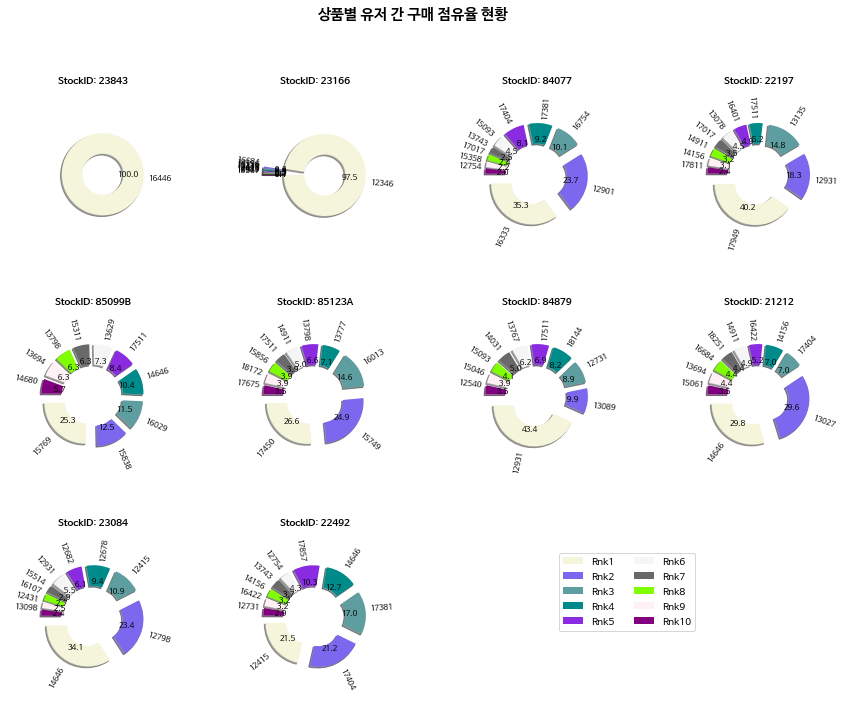

In [ ]:
active_stock = _df1.groupby('StockCode').Quantity.sum().sort_values(ascending=False).head(10).index
fig, axes = plt.subplots(3, 4, figsize=(15, 15), facecolor='#FFFFFF', sharex=True, sharey=True);
for axi in [2, 3]:
    fig.delaxes(ax= axes[2, axi])

'''
    * pon: pick_out_number
    * c_rank: 
'''

_, c_rank = zip(*matplotlib.colors.cnames.items())
pon = 10
max_id_len = max([len(_df1[_df1.StockCode == x].CustomerID.unique()) for x in active_stock])
if max_id_len > pon:
    top_n = 10
else:
    top_n = max_id_len

random.seed(2001); c_rank = random.sample(c_rank, top_n)
i = 0
for st_c in active_stock:
    sorted = _df1[_df1.StockCode == st_c].groupby('CustomerID').Quantity.sum() 
    if len(sorted) > top_n:
        n = top_n
    else:
        n = len(sorted)
        
    c_rankSUB = c_rank[ :n]
    ax  = axes[i // 4, i % 4]
    row = sorted.sort_values(ascending=False).head(n)
    ax.pie(
        row, labels = pd.Series(row.index).apply(lambda x: str(int(x))),
        colors=c_rankSUB,
        autopct = '%4.1f',
        textprops={'fontsize': 8}, 
        radius = .6, 
        startangle= 180, 
        wedgeprops=dict(width=.3),
        shadow = True,
        rotatelabels=True,
        explode = [np.float(0.15) for x in range(n)]
    )
    ax.set_title(f"StockID: {st_c}", fontweight='bold', fontsize=10)
    ax.set_ylabel("")

    legend = plt.legend([f'Rnk{x}' for x in range(1, 11)], 
                        bbox_to_anchor=(1.9, .9),
                        loc='upper left',  
                        ncol=2, 
                        prop={'size': 10},
                        fancybox=True)

    i += 1
fig.subplots_adjust(wspace=.3)   
title = fig.suptitle('상품별 유저 간 구매 점유율 현황', y=.95, fontweight='bold', fontsize=15)  
plt.subplots_adjust(bottom=0.3)

<font size = 2>위의 분석을 통해 고객 및 지역 기준 재방문 수를 확인할 수 있습니다.</font>

<font size = 2>고객의 경우 약 4000번을 기준으로 상위그룹이 구분됨을 알수 있습니다. 지역의 경우 영국이 독보적으로 높다는 것을 알 수 있습니다.</font>




In [ ]:
Cu_Co_Dt_Q = _df1.groupby(['CustomerID', 'StockCode', 'Inv_date'])['Quantity'].sum().reset_index()
CodeUL = Cu_Co_Dt_Q.iloc[Cu_Co_Dt_Q.Quantity.sort_values(ascending=False).index].iloc[:, 0].tolist()

groupedby_Cu_Co_Dt = Cu_Co_Dt_Q.groupby(by='CustomerID')
Cu_Co_Dt_top10 = [groupedby_Cu_Co_Dt.get_group( CodeUL[x] ).sort_values(by='Inv_date', ascending=True).reset_index(drop=True) for x in range(10)]

In [ ]:
def style_negative1(v, props=''):
    return (props if (type(v) == type(pd.to_datetime('2020-10-25 02:00 +0200'))) or (type(v) == int) else None)

a_group, b_group = [], []
for i in range(10): a_group.append(i) if len(Cu_Co_Dt_top10[i]) == 1 else b_group.append(i)

print(f"\n{color.BOLD}: 특정 고객의 하루 거래량의 상위 0.002%(10 위권) 이내이면서, 해당 일 거래 건이 1개(더 이상 일어나지 않은 경우)인 경우{color.END}\n")
print(f"{color.BOLD}{color.DARKCYAN}'CustomerID' | 'StockID' | 'Transaction date{color.END}'")
for top_singlei in operator.itemgetter(*a_group)(Cu_Co_Dt_top10): print(f"{top_singlei.values[0][0]},       {top_singlei.values[0][1]},       {top_singlei.values[0][2].strftime('%d %B, %Y')}")


: 특정 고객의 하루 거래량의 상위 0.002%(10 위권) 이내이면서, 해당 일 거래 건이 1개(더 이상 일어나지 않은 경우)인 경우

'CustomerID' | 'StockID' | 'Transaction date'
12346.0,       23166,       18 January, 2011
13135.0,       22197,       27 May, 2011
18087.0,       22053,       22 February, 2011


In [ ]:
def vis_customer_trading_quant(input_i=b_group[0]):

    # Step1
    y = Cu_Co_Dt_top10[input_i].copy(); y_origin = Cu_Co_Dt_Q.copy()

    Q1  = y_origin[y_origin.Quantity != 0].iloc[:, -1].quantile(.25)
    Q3  = y_origin[y_origin.Quantity != 0].iloc[:, -1].quantile(.75)
    IQR = Q3 - Q1

    Lower_fence = Q1-1.5*(IQR)
    Upper_fence = Q3+1.5*(IQR)

    def interquartile_range(x):
        if x > Upper_fence:
            y = float(0.5)
        elif (x >= Lower_fence) and (x < Q1):
            y = float(-0.25)
        elif (x >= Q1) and (x <= Q3):
            y = float(0.25)
        else:
            y = float(-0.5)
        return y

    y['interquartile_range'] = y.Quantity.apply(interquartile_range)
    y_Usc      = y.StockCode.unique().tolist()
    groupby_Sc = y.groupby(by='StockCode')
    
    # Step2
    resL = []
    for i in range(len(y_Usc)):
        n_suby     = groupby_Sc.get_group(y_Usc[i])
        time_rng = pd.date_range(start=min(y.Inv_date), end=max(y.Inv_date), freq='d').tolist()

        not_in_intersection = set(set(n_suby['Inv_date'])) ^ set(time_rng)
        def cr_missing_val(input_val, rep_num):
            return np.repeat(input_val, rep_num, axis=0)
        lst_of_tuples = list(zip(
            cr_missing_val(n_suby.iloc[0, 0], len(not_in_intersection)),
            cr_missing_val(n_suby.iloc[0, 1], len(not_in_intersection)),
            not_in_intersection,
            cr_missing_val(float(+0.0), len(not_in_intersection)),
            cr_missing_val(float(-0.5), len(not_in_intersection))
        ))
        y_ = pd.DataFrame(lst_of_tuples, columns=y.columns)
        res = pd.concat([n_suby, y_], axis=0).sort_values('Inv_date').reset_index(drop=True)
        resL.append(res)

    # Step3
    y_byCustomer = pd.concat(resL).reset_index(drop=True)
    y_byCustomer['x_steps'] = [1]*len(y_byCustomer)

    fig = px.bar(y_byCustomer, x="x_steps", y="StockCode", color='interquartile_range', orientation='h',
                hover_data=["Inv_date", "Quantity", "interquartile_range"],
                color_continuous_scale='jet',
                height=300, width =1200,
                title=''
                )

    Qs = y_byCustomer.iloc[:, -3]; 
    Q_interval_to_max = int((max(y_byCustomer[Qs == max(Qs)].iloc[:, 2]) - min(y_byCustomer['Inv_date'])).days); 
    y_position = np.where(y_byCustomer.StockCode.unique() == y_byCustomer[Qs == max(Qs)].StockCode.values[0])[0][0];

    if len(y_byCustomer) > 1:
        vis_acc = True
        fig.add_shape(type="circle", 
                    xref="x", yref="y", x0=Q_interval_to_max-2, y0=y_position-1, x1=Q_interval_to_max+3, y1=y_position+1,
                    line=dict(
                        color="lime",
                        width=5,
                        dash="dot",
                        )
                    )
    else:
        vis_acc = False

    x_labels = [x.strftime('%Y-%m-%d') for x in time_rng]
    if len(x_labels) > 9:
        indL = list(range(len(x_labels)))
        a, c = 0, int(len(x_labels) - 1)
        b = int(pd.Series(indL).median(skipna = True))
        x_labels_ = ['']*len(x_labels)
        for dt_i in [a, b, c]:
            x_labels_[dt_i] = x_labels[dt_i]
        x_labels = copy.deepcopy(x_labels_)    
    fig.update_xaxes(
        tickvals=np.arange(len(x_labels)), ticktext=x_labels,
        tickfont_size=9, ticks="outside", ticklen=1, tickwidth=1, tickangle=45
        )
    fig.update_yaxes(tickfont_size=9, ticks="outside", ticklen=1, tickwidth=1)

    fig.update_layout(
        title=f"<b>Customer_ID: {int(y_byCustomer.iloc[0, 0])}</b>, <i>Trade quantity: {int(max(Qs))}, Date: {max(y_byCustomer[Qs == max(Qs)].iloc[:, 2]).strftime('%d %B, %Y')}</i>", 
        xaxis=dict(
            rangeslider=dict(
                autorange=True,
                range=[x_labels[0], x_labels[-1]],
                visible=vis_acc),
                type="linear"
                ),
                
        font=dict(
            family="Courier New, monospace",
            size=9,
            color="gray"),
        width=1200,
        )
    
    return fig.show(renderer="colab")

In [ ]:
vis_customer_trading_quant(input_i=b_group[0])

In [ ]:
vis_customer_trading_quant(input_i=b_group[1])

In [ ]:
vis_customer_trading_quant(input_i=b_group[2])

In [ ]:
vis_customer_trading_quant(input_i=b_group[3])

In [ ]:
vis_customer_trading_quant(input_i=b_group[4])

In [ ]:
vis_customer_trading_quant(input_i=b_group[5])

In [ ]:
vis_customer_trading_quant(input_i=b_group[6])

---

<font size = 2>단가 표준편차의 평균 이상의 "StockCode"만을 추가로 선별하겠습니다.</font>

In [ ]:
# preprocessing
price_nunq  = _df1.groupby('StockCode').UnitPrice.nunique()
over3_codes = list(set(price_nunq[price_nunq >= 3].index))
indexes = list(map(lambda x: np.where(_df1.reset_index(drop=True).StockCode == x)[0].tolist(), over3_codes)); m_indexes = sum(indexes, [])

over3_df = _df1.reset_index(drop=True).iloc[sorted(m_indexes)].reset_index(drop=True)
over3_df.loc[:, 'InvoiceDate'] = over3_df.InvoiceDate.apply(lambda x: pd.to_datetime(x))
over3_dfFv = over3_df.loc[:, ['InvoiceDate', 'StockCode',	'Quantity',	'UnitPrice']].copy()

# visualization
_, c_items = zip(*matplotlib.colors.cnames.items())
random.seed(2022)
c_items = [random.choice(c_items) for x in range(len(over3_dfFv.StockCode.unique()))]

def ts_vis(target_col='UnitPrice'):
    var_avg = np.mean(over3_dfFv.groupby(['StockCode'])[target_col].apply(lambda x: np.var(x)).sort_values(ascending=False))
    
    fig  = plt.figure( figsize=(16, 6) )
    axes = [plt.subplot2grid((1, 3), (0, 0), colspan=2), plt.subplot2grid((1, 3), (0, 2))]
    i = 0
    for key, gr in over3_dfFv.groupby(by='StockCode'):
        if np.var(gr[target_col]) > var_avg:
            lab = key
        else:
            lab = None
        axes[0].bar(gr.InvoiceDate, gr[target_col], color=c_items[i], label=lab, alpha=0.4)
        i += 1

    axes[0].legend(loc='upper left')
    axes[0].set_title(f'{target_col}의 변화 및 StockCode별 표준편차가 이의 평균을 넘어서는 상품을 분류')
    axes[0].set_xlabel('TIme')
    axes[0].set_ylim(0, round(np.max(over3_dfFv[target_col])) * 1.25)
    axes[0].set_ylabel(target_col)

    axes[1].boxplot(over3_dfFv[target_col])
    axes[1].set_title(f"Boxplot for {target_col}")
    
    for j in range(2):
        axes[j].grid()
        for label in axes[j].get_xticklabels(which='major'):
            label.set(rotation=45, horizontalalignment='right')

    fig.tight_layout()

    return plt.show()    

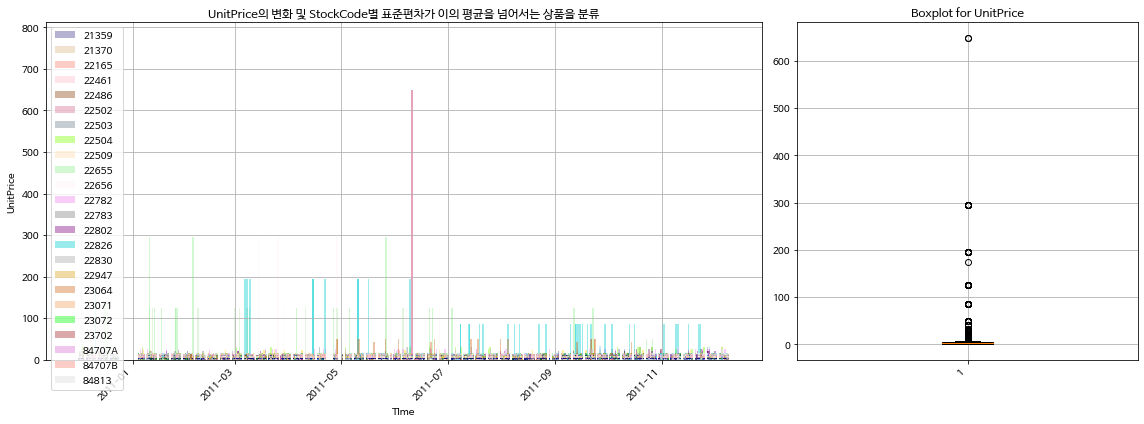

In [ ]:
print('\n')
ts_vis(target_col='UnitPrice')

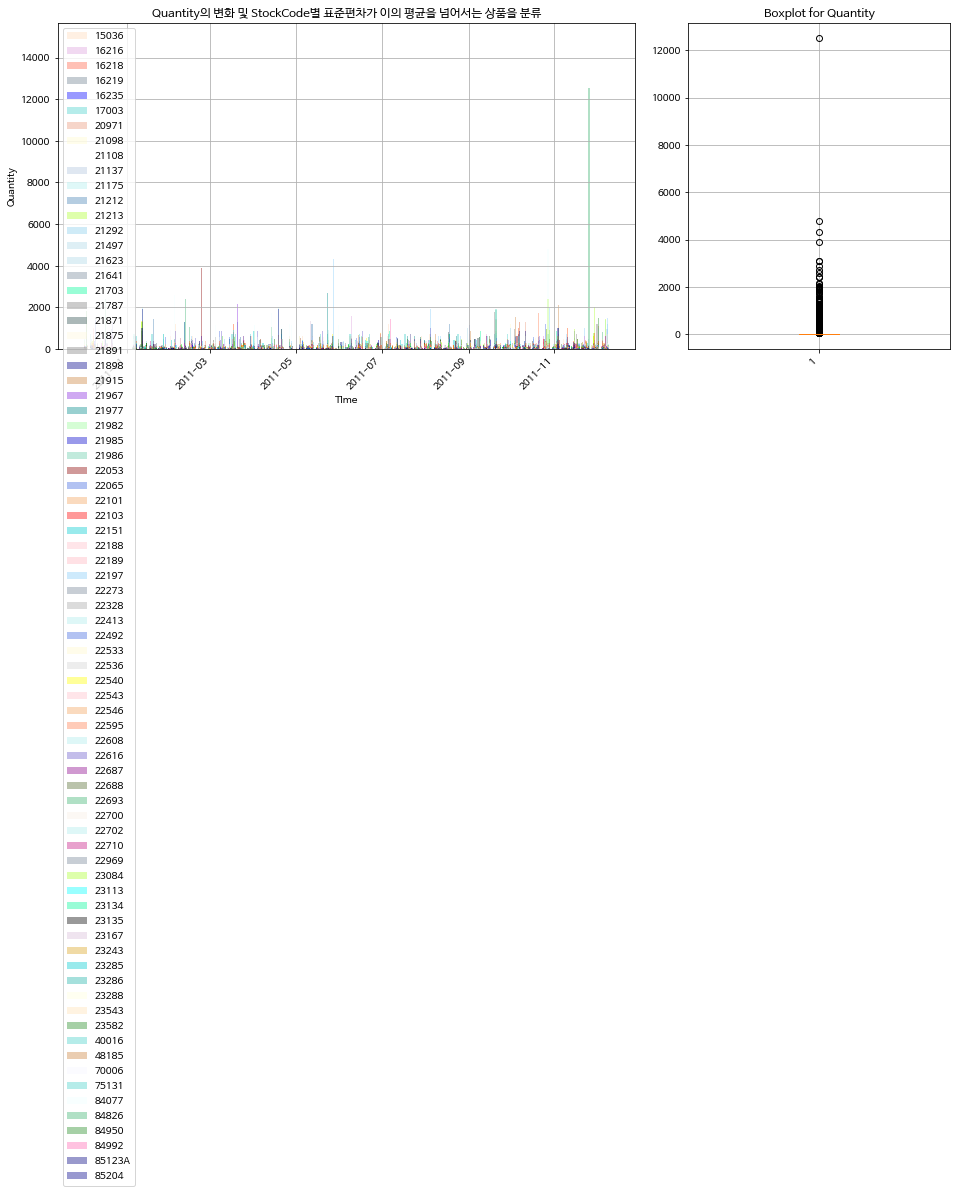

In [ ]:
print('\n')
ts_vis(target_col='Quantity')

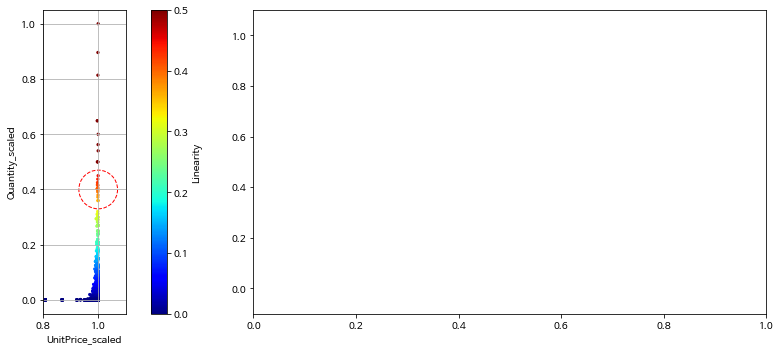

In [ ]:
price_quant = over3_dfFv.loc[:, ['UnitPrice', 'Quantity']].values.tolist()
scaler = MinMaxScaler()
scaler.fit(price_quant)
price_quant_new = scaler.transform(price_quant); a, b = zip(*price_quant_new); a = pd.Series(a)

price_quant_newDF = pd.DataFrame( columns=['UnitPrice_scaled', 'Quantity_scaled'] )
a[a > 0] = 1 - a; price_quant_newDF.iloc[:, 0] = a
price_quant_newDF.iloc[:, 1] = b; price_quant_newDF = price_quant_newDF[price_quant_newDF.UnitPrice_scaled > 0].reset_index(drop=True).copy()

'''
* Solution one
'''
comparison  = (price_quant_newDF.iloc[:, 0] >= price_quant_newDF.iloc[:, 1])
rise1_run0 = np.where(comparison == True )[0]
rise0_run1 = np.where(comparison == False)[0]
price_quant_newDF.loc[rise1_run0, 'Linearity'] = price_quant_newDF.iloc[rise1_run0, 1]/price_quant_newDF.iloc[rise1_run0, 0]
price_quant_newDF.loc[rise0_run1, 'Linearity'] = price_quant_newDF.iloc[rise0_run1, 0]/price_quant_newDF.iloc[rise0_run1, 1]

'''
* Solution two
> price_quant_newDF.loc[:, 'Linearity'] = price_quant_newDF.iloc[:, 1]/price_quant_newDF.iloc[:, 0]
'''

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
price_quant_newDF.plot(kind='scatter', x='UnitPrice_scaled', y='Quantity_scaled',
                       c='Linearity', ax=axes[0], cmap='jet', vmin=0, vmax=0.5, s=5)

c = plt.Circle((1, 0.4), 0.07, fill=False, color='r', ls='--')
axes[0].set_aspect(1)
axes[0].add_artist(c)

axes[0].set_xlim(0.8,1.1); plt.ylim(-0.1,1.1)
axes[0].grid(True)
plt.tight_layout()